<a href="https://colab.research.google.com/github/absallh/GP/blob/master/GP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Get IceVision framwork

The IceVision framework will be used for parsing, transforming and modelling. 

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh
from icevision.all import *

--2021-10-08 20:35:43--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘install_colab.sh.1’

install_colab.sh.1  100%[===================>]     595  --.-KB/s    in 0s      

2021-10-08 20:35:43 (23.4 MB/s) - ‘install_colab.sh.1’ saved [595/595]

- Installing mmcv
mmcv-full==1.3.14 existed.
- Installing mmdet
mmdet==2.17.0 existed.
- Installing icevision from master
- Installing icedata from master
- Installing yolov5-icevision
Installation completed!
Please Restart Kernel!
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


#Read dataset

In [ ]:
#The VOCBBoxParser class automatically arranges the information on the images, 
#labels and bboxes, including fixing illogical coordinates.
images_dir = '/content/gdrive/MyDrive/BCCD_Dataset-master/BCCD/JPEGImages'
annotations_dir = '/content/gdrive/MyDrive/BCCD_Dataset-master/BCCD/Annotations'
parser = parsers.VOCBBoxParser(images_dir = images_dir, annotations_dir = annotations_dir)

In [ ]:
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/364 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/364 [00:00<?, ?it/s]

AUTOFIX-FAIL - (record_id: BloodImage_00338) - Cannot auto-fix coordinates: <BBox (xmin:504, ymin:337, xmax:504, ymax:337)>
	x_min:504 is greater than or equal to x_max:504
	y_min:337 is greater than or equal to y_max:337 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: BloodImage_00338) Removed annotation with index: 12, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:50
AUTOFIX-FAIL - (record_id: BloodImage_00343) - Cannot auto-fix coordinates: <BBox (xmin:181, ymin:329, xmax:181, ymax:329)>
	x_min:181 is greater than or equal to x_max:181
	y_min:329 is greater than or equal to y_max:329 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: BloodImage_00343) Removed annotation with index: 3, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:50


<ClassMap: {'background': 0, 'WBC': 1, 'RBC': 2, 'Platelets': 3}>

#Transforms

this is the preprocessing (resize, normalization and augmentation)

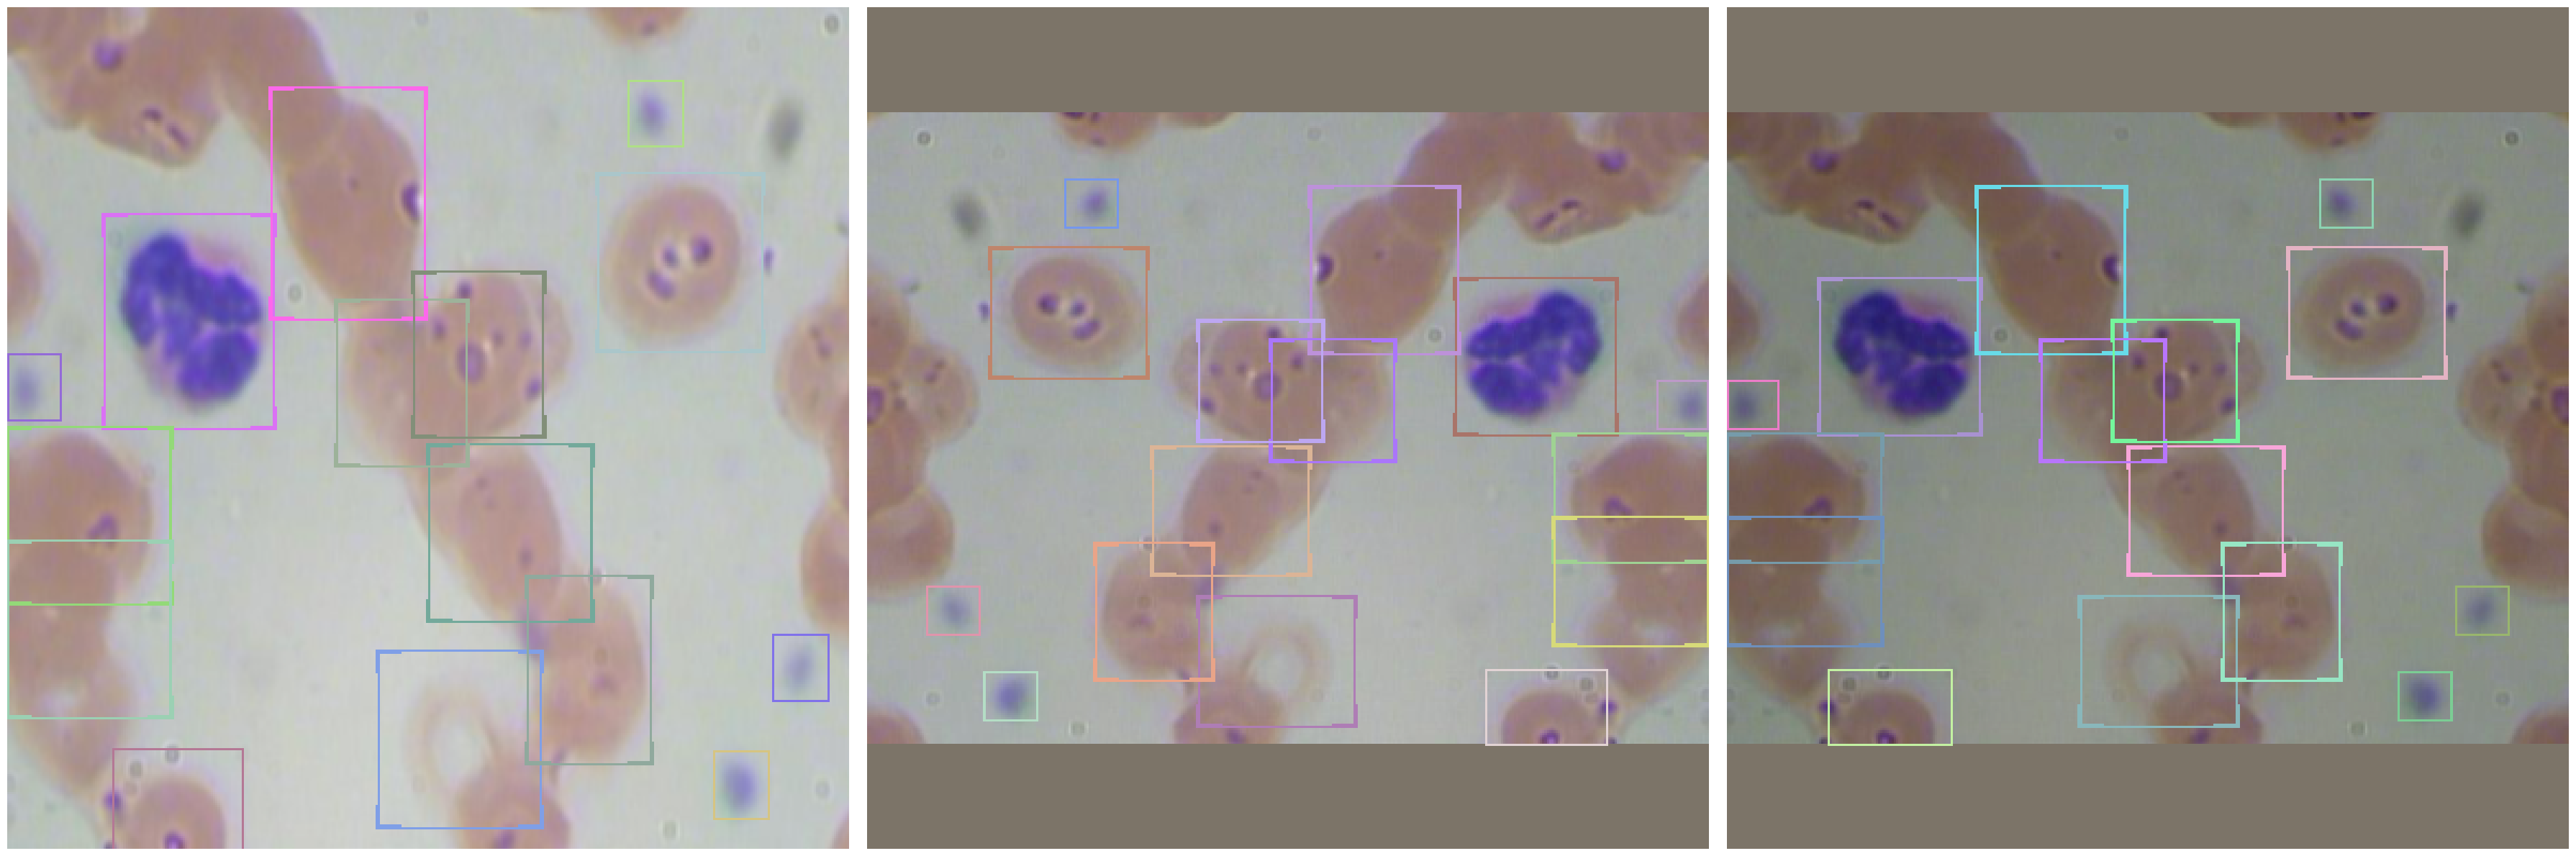

In [ ]:
presize = 512
size = 384
train_tfms = tfms.A.Adapter(
 [*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter(
 [*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False)

#Modeling

In [ ]:
#function to plot model results
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
        'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

build YOLOv5 model

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


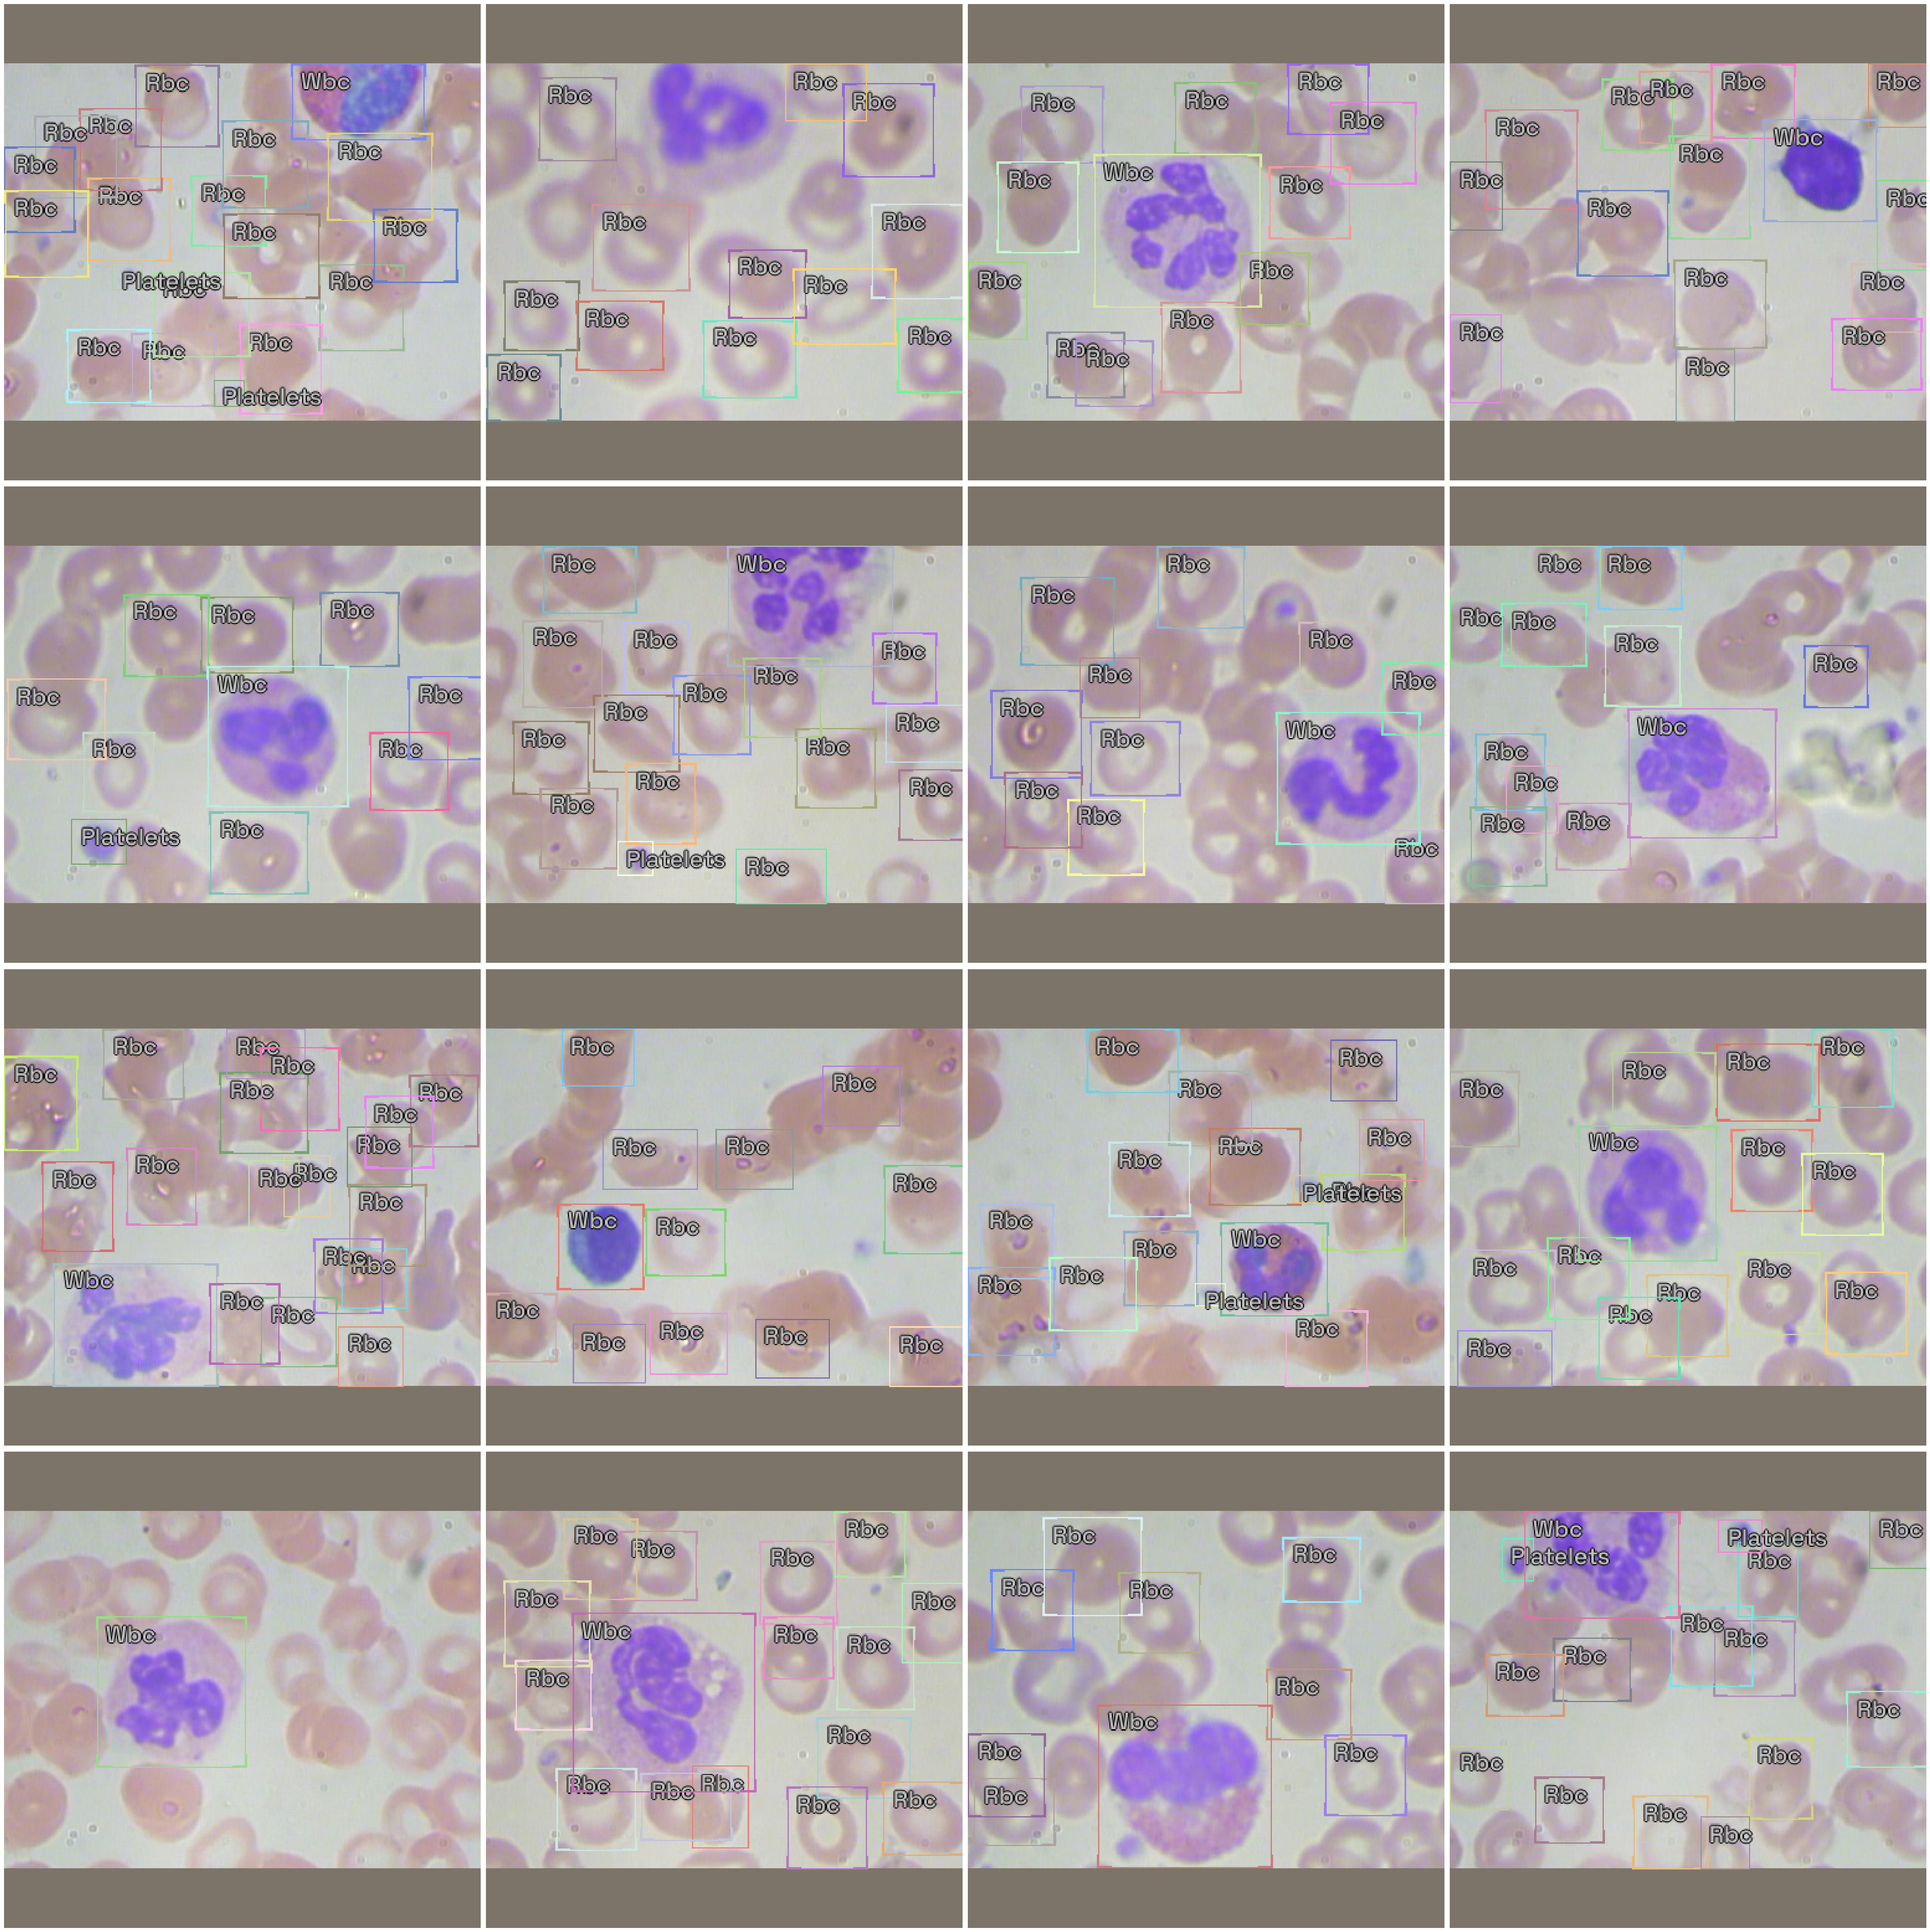

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.ultralytics.yolov5 
backbone = model_type.backbones.small 
model = model_type.model(
                backbone = backbone(pretrained=True), 
                num_classes=len(parser.class_map), img_size = size)
train_dl = model_type.train_dl(
             train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(
             valid_ds, batch_size=16, num_workers=4, shuffle=False)
                                       
learn = model_type.fastai.learner(
             dls=[train_dl, valid_dl], model=model, metrics=metrics)
model_type.show_batch(first(valid_dl), ncols=4)

#train the model

In [ ]:
learn = model_type.fastai.learner(
          dls=[train_dl, valid_dl], model=model, metrics=metrics)
# learn.lr_find()
from fastai.callback.tracker import SaveModelCallback
fname='bccd-faster-rcnn-best'
learn.fine_tune(50, 1e-02, freeze_epochs=1, cbs=SaveModelCallback(monitor='COCOMetric', fname=fname))

Better model found at epoch 0 with COCOMetric value: 0.018321940694677935.


Better model found at epoch 0 with COCOMetric value: 0.07085104009245011.
Better model found at epoch 1 with COCOMetric value: 0.1943174041442099.
Better model found at epoch 2 with COCOMetric value: 0.2858051237750387.
Better model found at epoch 3 with COCOMetric value: 0.4324074216758214.
Better model found at epoch 5 with COCOMetric value: 0.46108928436713775.
Better model found at epoch 7 with COCOMetric value: 0.46686079684632015.
Better model found at epoch 17 with COCOMetric value: 0.4884435785744319.
Better model found at epoch 18 with COCOMetric value: 0.5212461164230898.
Better model found at epoch 26 with COCOMetric value: 0.5498280622159537.
Better model found at epoch 29 with COCOMetric value: 0.585539063540081.


#Predict

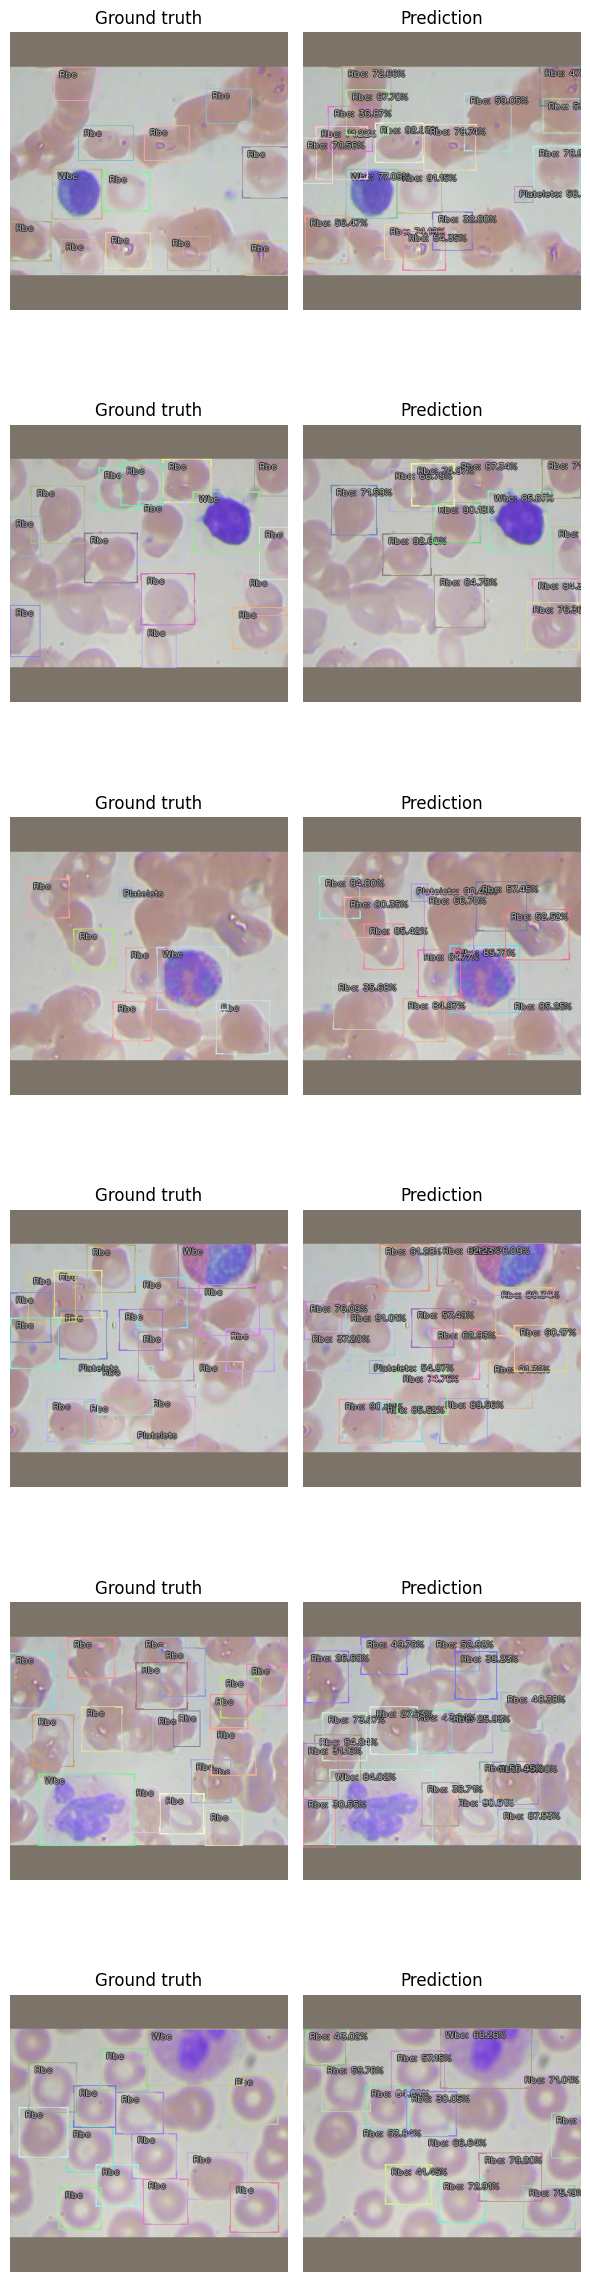

In [ ]:
model_type.show_results(model, valid_ds)

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/19 [00:00<?, ?it/s]

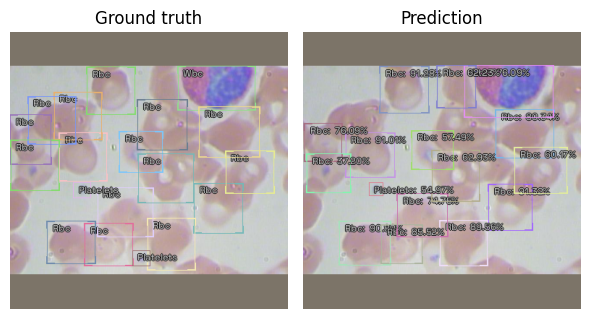

In [ ]:
show_preds(preds=preds[:1])

In [ ]:
print(len(valid_ds))
infer_dl = model_type.infer_dl(valid_ds, batch_size=1)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

73


  0%|          | 0/73 [00:00<?, ?it/s]

In [ ]:
#count the RBC in the image
preds[0].pred.as_dict()['detection']['labels'].count('RBC')

14

#Test

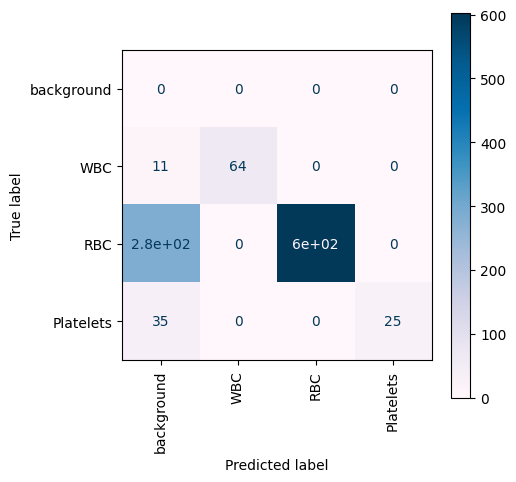

In [ ]:
cm = SimpleConfusionMatrix(iou_threshold=0.8)
cm.accumulate(preds)
_ = cm.finalize()

cm.plot(figsize=5, normalize=None)

In [ ]:
!pip install fastai==2.3.1 --upgrade -q
from sklearn.metrics import average_precision_score

interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix(figsize=(6,6))
interpret.most_confused(min_val=3)

TypeError: ignored